In [118]:
import json
import numpy as np
import pandas as pd
from geopy.distance import geodesic
from haversine import haversine, Unit


Ponizej funkcje uzywane do analizy online danych i tworzenia do tego Data Frame


In [121]:
# # Function to calculate distance between two points
def calculate_distance(row):
    coords1 = (row['Lat'], row['Lon'])
    coords2 = (row['prev_lat'], row['prev_lon'])
    return haversine(coords1, coords2, unit=Unit.METERS)
    # return geodesic(coords1, coords2).meters

# # Function to calculate speed
def calculate_speed(row):
    if row['time_diff'] == 0:
        return 0
    else:
        return row['distance'] / row['time_diff']

In [122]:
def data_with_speeds(path, speed_limit):
    df = pd.read_json(path)

    # Assuming df is your dataframe
    # Convert 'Time' column to datetime objects
    df['Time'] = pd.to_datetime(df['Time'])


    # # Sort the dataframe by 'VehicleNumber' and 'Time'
    df = df.sort_values(by=['VehicleNumber', 'Time'])

    

    # # Shift the dataframe to get previous values for distance calculation
    df[['prev_lat', 'prev_lon']] = df.groupby('VehicleNumber')[['Lat', 'Lon']].shift(1)
    df['distance'] = df.apply(calculate_distance, axis=1)

    # # Calculate time difference
    df['time_diff'] = (df['Time'] - df['Time'].shift(1)).dt.total_seconds()

    # # Calculate speed
    df['Speed'] = df.apply(calculate_speed, axis=1) * 3600 / 1000  # convert m/s to hm/h

    # # Drop rows where there's no previous point for a vehicle
    df = df.dropna(subset=['prev_lat', 'prev_lon'])

    # filtering out not moving buses
    filtered_df = df[df['Speed'] > 1]

    max_speeds = filtered_df.groupby('VehicleNumber')['Speed'].max()
    print(max_speeds.nlargest(10))

    speeds_over_50_count = filtered_df[(filtered_df['Speed'] > 50) & (filtered_df['Speed'] <= speed_limit)].groupby('VehicleNumber')['Speed'].count()

    num_rows = len(speeds_over_50_count)

    too_fast = (filtered_df['Speed'] > speed_limit).mean() * 100
    print(f"Percentage of speeds over 50: {too_fast:.2f}%")

    print("Too fast records:", num_rows)

    filtered_df = filtered_df[filtered_df['Speed'] <= speed_limit]

    return filtered_df


In [123]:
dzienne = data_with_speeds('data/2002_1407.json', 85)


VehicleNumber
2242    152.448381
2025    119.996572
9812    115.551480
3413     97.496637
9063     87.946672
3408     82.378597
9947     81.855458
8322     81.087575
9835     78.526313
7210     77.909058
Name: Speed, dtype: float64
Percentage of speeds over 50: 0.01%
Too fast records: 462


In [46]:
wieczorne = data_with_speeds('data/2102_1908.json', 85)

VehicleNumber
8589    342.916815
6210    135.014958
8317    113.046318
762     106.492711
9311     98.393126
9090     90.024684
8842     87.380009
8879     84.983044
9814     84.129954
1993     83.487038
Name: Speed, dtype: float64
Percentage of speeds over 50: 0.01%
Too fast records: 379


Widzimy ze liczba przekroczen predkosci dla 14:00 to 462 

zaledwnie 0.01% predkosci bylo wieksze niż 85km/h i jednoczesnie wydaje sie to sensowy gorny limit predkosci
wobec tego odfiltrujemy wszystkie wieksze


Definiuje pojecie lokalizacji troche podobnie to punktu z promieniem, mianowicie zamist okregu u mnie jest to kwadracik na mapie,

jesli sa one dosc geste jest to dosc elestatyczne, bo jesli mamy taki zbior kwadracikow to mamy potem duza elastycznosc.

Mozemy sami oszacowac, zinterpolowac dowolna ulice obiekt itp. i sprawdzic jak pokrywa sie z naszymi kwadracikami

Przyjalem ze kwadracik ma 500m dlugosc

In [78]:
interval = 0.005

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

def location_data_frame(data_frame):
    df = data_frame.copy()

    # Convert columns to numeric
    df['Lat'] = pd.to_numeric(df['Lat'], errors='coerce')
    df['Lon'] = pd.to_numeric(df['Lon'], errors='coerce')
    df['Speed'] = pd.to_numeric(df['Speed'], errors='coerce')

    # Filter data based on latitude and longitude ranges
    filtered_df = df[(df['Lat'] >= 51) & (df['Lat'] <= 53) & (df['Lon'] >= 20) & (df['Lon'] <= 22) & (df['Speed'] > 50)].copy()

    lat_interval = interval
    lon_interval = interval

    # Bin the latitude and longitude values into intervals
    filtered_df['Lat_bin'] = pd.cut(filtered_df['Lat'], bins=np.arange(51, 53, lat_interval))
    filtered_df['Lon_bin'] = pd.cut(filtered_df['Lon'], bins=np.arange(20, 22, lon_interval))

    return filtered_df

In [75]:
def heatmap_speed_break(data_frame):
    # Create a pivot table with aggregated values
    pivot_table = pd.pivot_table(data_frame, values='Speed', index='Lat_bin', columns='Lon_bin', aggfunc=np.count_nonzero)

    # Create heatmap
    plt.figure(figsize=(10, 8))
    # ax = sns.heatmap(data=pd.pivot_table(filtered_df, values='Speed', index='Lat_bin', columns='Lon_bin'), cmap='coolwarm', linewidths=0.5)
    ax = sns.heatmap(data=pivot_table, cmap='coolwarm', linewidths=0.5)

    plt.title('Heatmap of Speed limit break (Latitude: 51-53, Longitude: 20-22)')
    ax.invert_yaxis()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [101]:
def heatmap_speed(data_frame):
    # Create a pivot table with aggregated values
    pivot_table = pd.pivot_table(data_frame, values='Speed', index='Lat_bin', columns='Lon_bin', aggfunc='mean')

    # Create heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(data=pivot_table, cmap='coolwarm', linewidths=0.5)

    plt.title('Heatmap of Speed (Latitude: 51-53, Longitude: 20-22)')
    ax.invert_yaxis()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    cbar = ax.collections[0].colorbar
    cbar.set_label('Speed')

    plt.show()

In [124]:
dzienne_punkty = location_data_frame(dzienne)
wieczorne_punkty = location_data_frame(wieczorne)



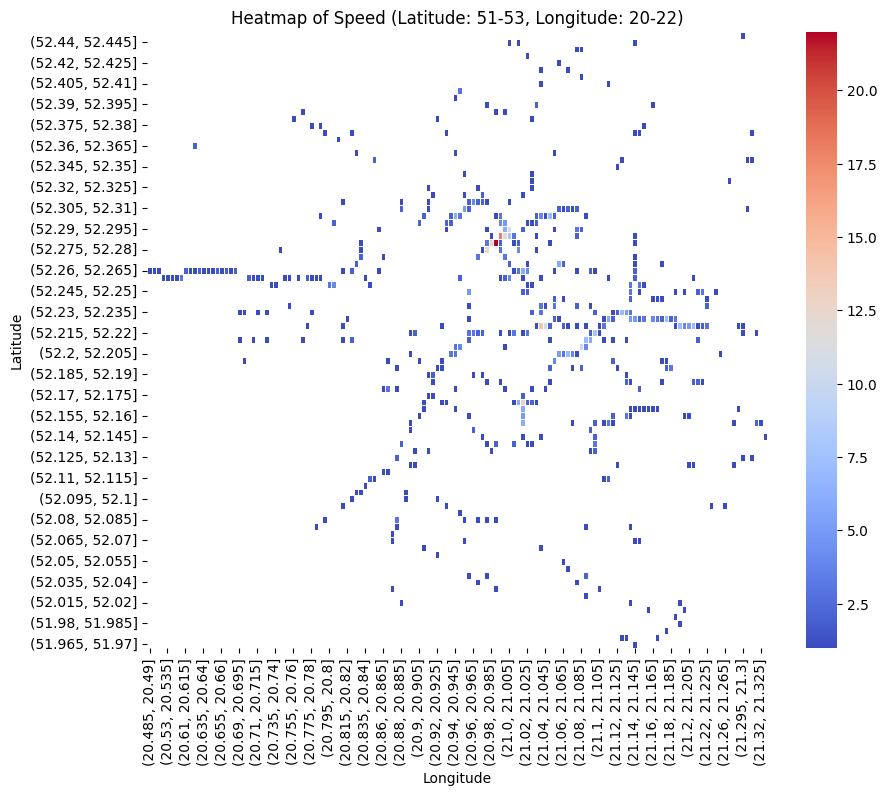

In [80]:
heatmap_speed_break(dzienne_punkty)

najwiecej przekroczen bylo tutaj
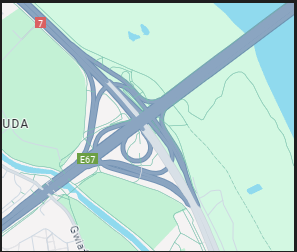

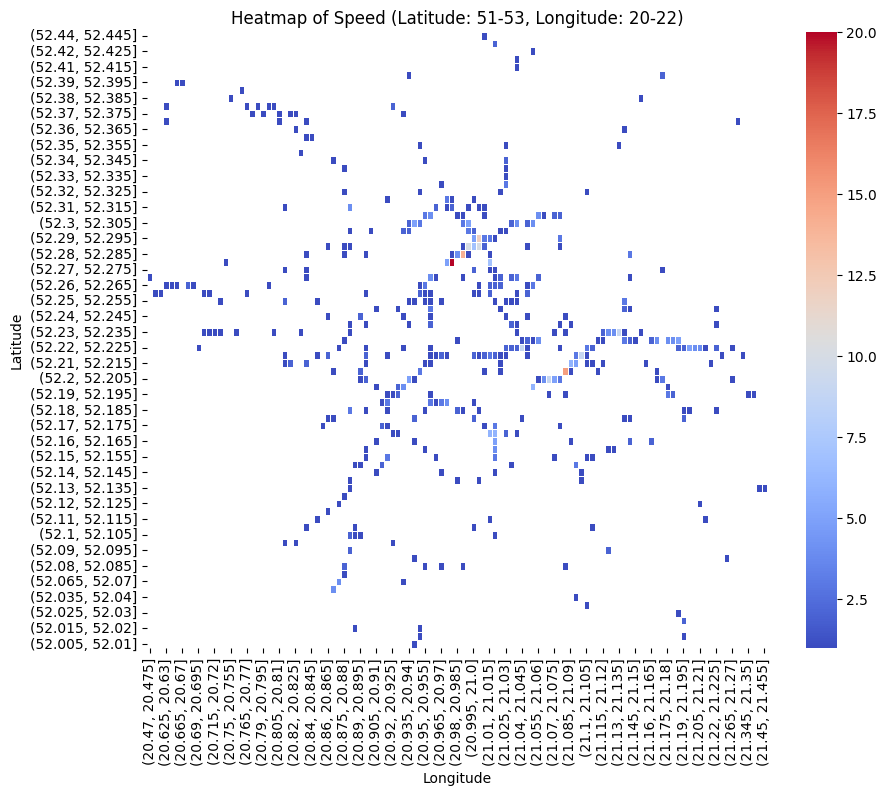

In [81]:
heatmap_speed_break(wieczorne_punkty)

In [86]:

def plot_mean_speed_per_line(data_frame):
    # Group the data by 'VehicleNumber' and calculate the mean speed for each vehicle
    mean_speed_per_vehicle = data_frame.groupby('Lines')['Speed'].mean

    mean_speed_per_vehicle = mean_speed_per_vehicle[mean_speed_per_vehicle > 10]

    # print(mean_speed_per_vehicle)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.bar(mean_speed_per_vehicle.index, mean_speed_per_vehicle.values, color='skyblue')
    plt.xlabel('Lines')
    plt.ylabel('Mean Speed')
    plt.title('Mean Speed per VehicleNumber')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



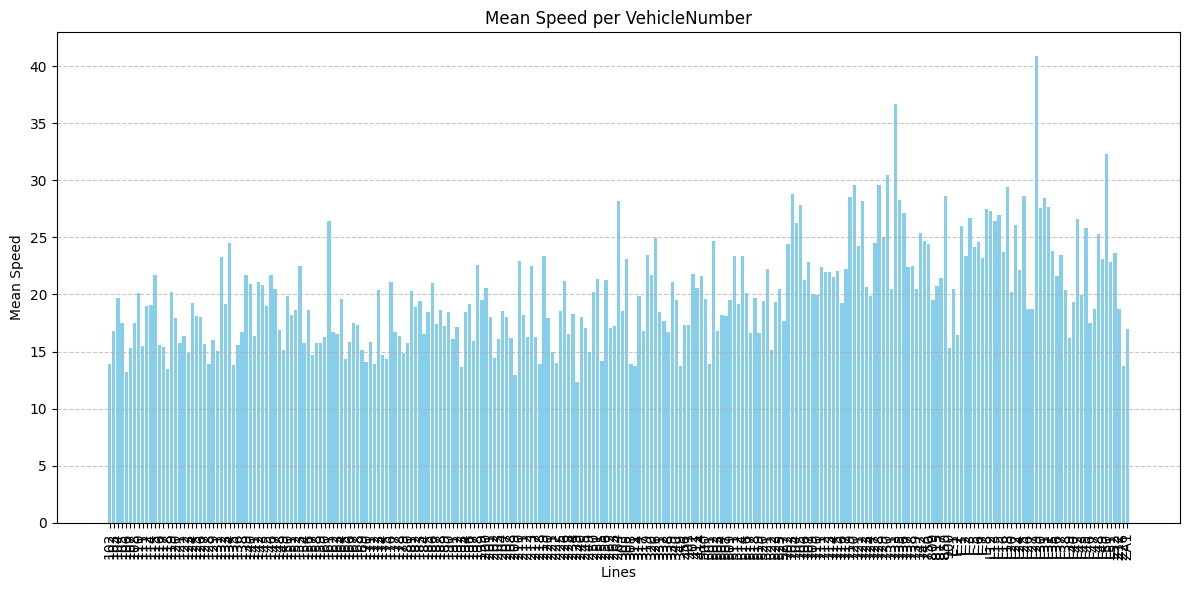

In [49]:
plot_mean_speed_per_line(dzienne)

In [104]:
def speed_limit_break_per_line(data_frame, treshold = 4):
    lines_over_50 =  data_frame[data_frame['Speed'] > 50].groupby('Lines')['Speed'].count()
    lines_over_50 = lines_over_50[treshold > 4]
    # print(lines_over_50)

    plt.figure(figsize=(12, 6))
    plt.bar(lines_over_50.index, lines_over_50.values, color='skyblue')
    plt.xlabel('Lines')
    plt.ylabel('speed limit break')
    plt.title('Speed limit break')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

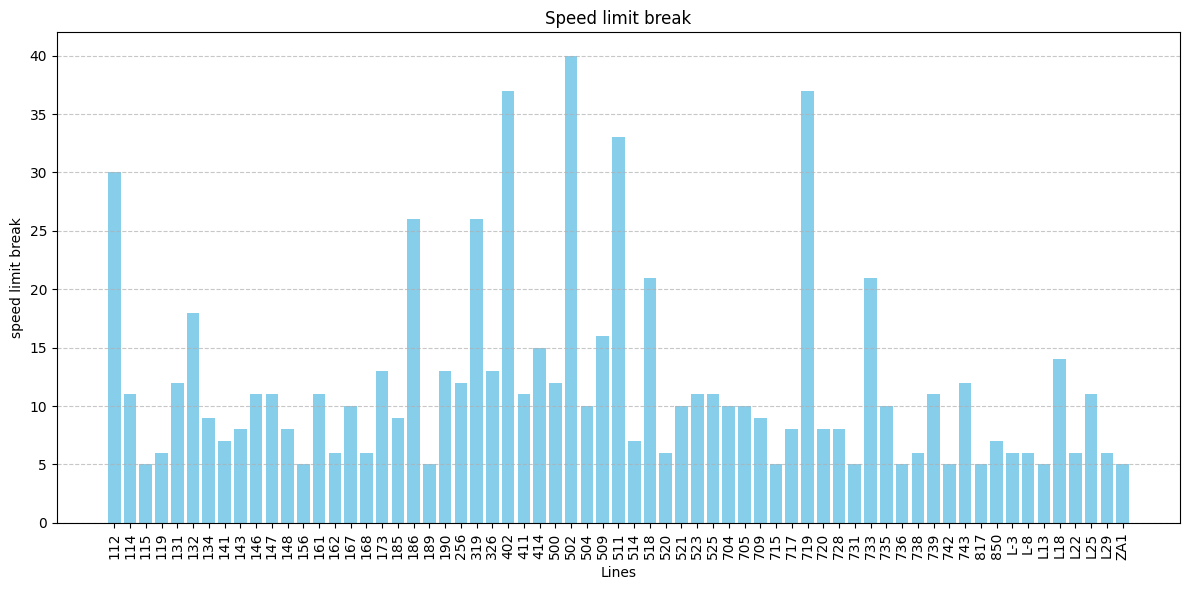

In [60]:
speed_limit_break_per_line(dzienne, 4)

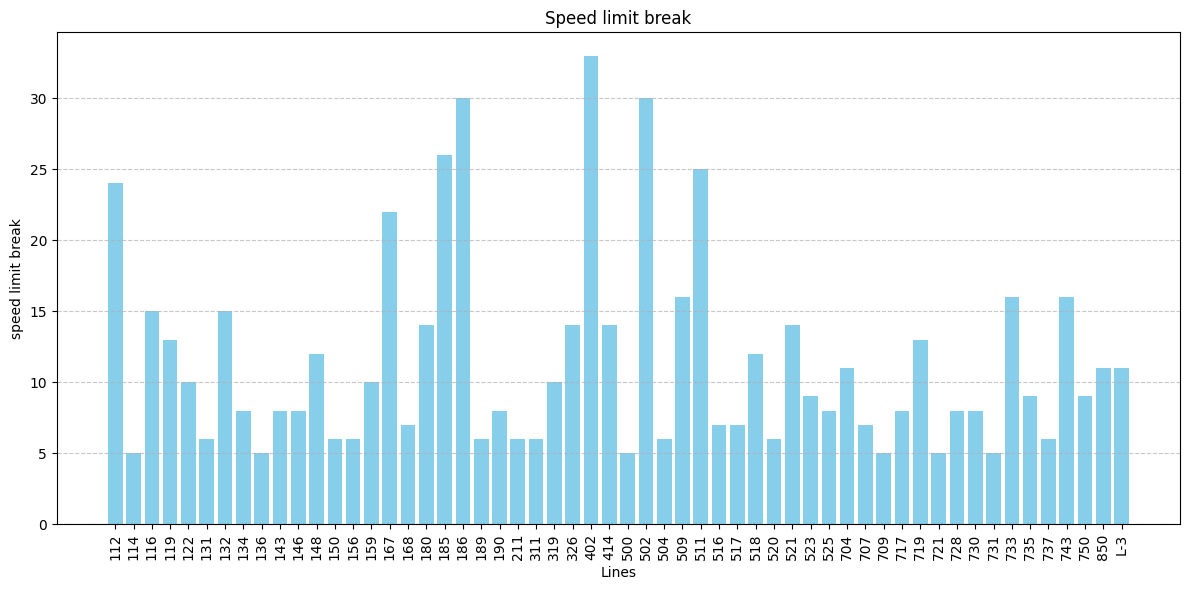

In [61]:
speed_limit_break_per_line(wieczorne, 4)

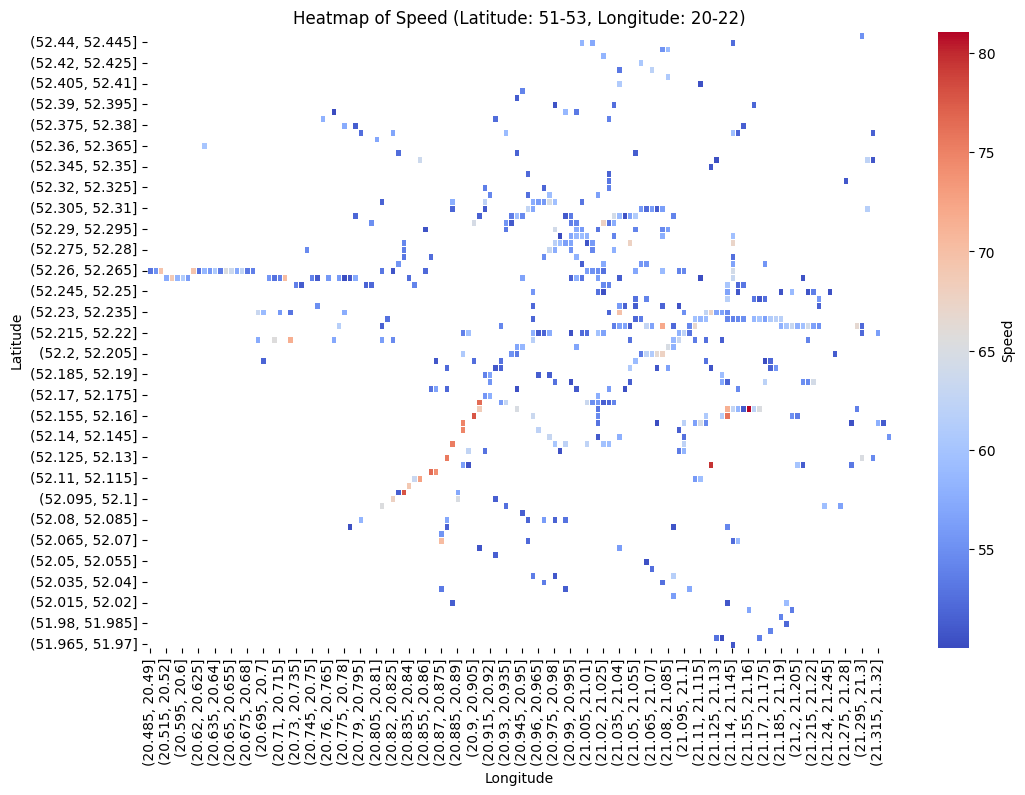

In [102]:
heatmap_speed(dzienne_punkty)

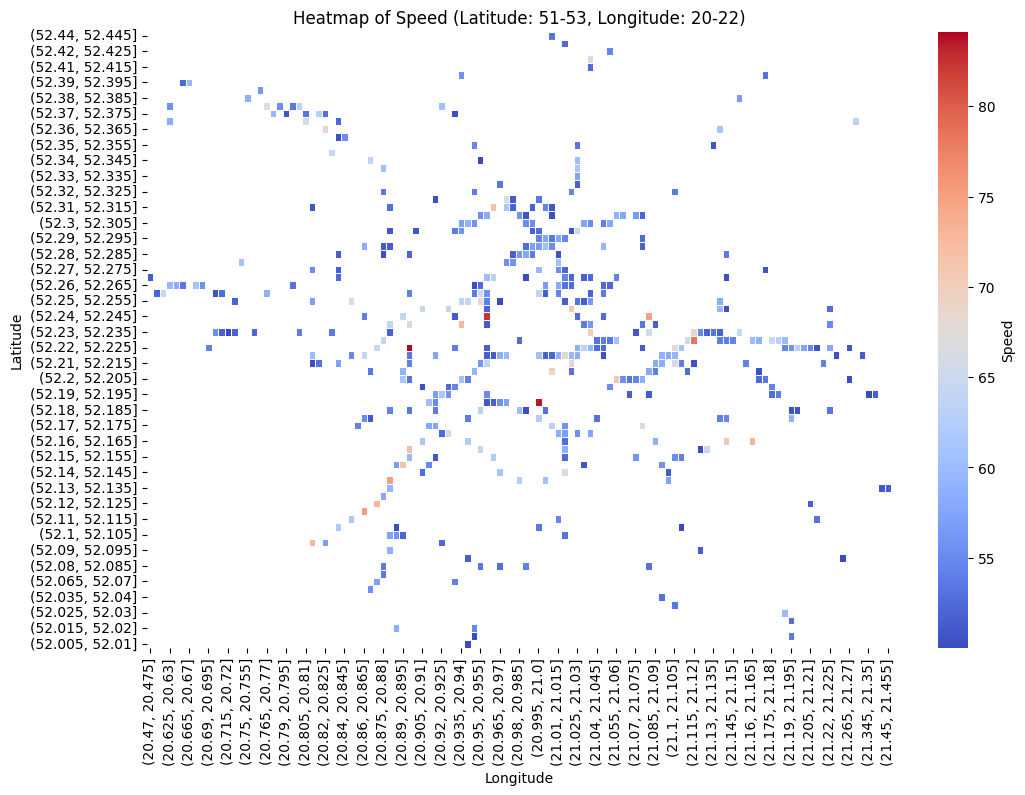

In [103]:
heatmap_speed(wieczorne_punkty)

In [112]:
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

def visualise_data_on_map(data_frame, save_name):
    df = data_frame

    # Create base map
    m = folium.Map(location=[52.35, 20.85], zoom_start=10)

    # Create a MarkerCluster object
    marker_cluster = MarkerCluster().add_to(m)

    # Add markers to the map
    for idx, row in df.iterrows():
        folium.Marker(
            location=[row['Lat'], row['Lon']],
            popup=f"Vehicle Number: {row['VehicleNumber']}<br>Time: {row['Time']}<br>Speed: {row['Speed']}",
            icon=None,
        ).add_to(marker_cluster)

    # Display the map
    m.save(f'{save_name}.html')

In [113]:
visualise_data_on_map(dzienne_punkty, 'dzienne')
visualise_data_on_map(wieczorne_punkty, 'wieczorne')
